In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time


In [2]:


class SceneClassifier:
    def __init__(self, data_dir, num_classes=4, img_size=224, batch_size=32):
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.img_size = img_size
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Enhanced data transforms with augmentation
        self.train_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(self.img_size, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])
        
        self.val_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.setup_data()
        self.setup_model()
        
    def setup_data(self):
        """Setup data loaders with proper transforms"""
        try:
            # Handle nested folder structure: my_dataset/train/train/classes
            train_path = os.path.join(self.data_dir, 'seg_train', 'seg_train')
            test_path = os.path.join(self.data_dir, 'seg_test', 'seg_test')
            
            # Check if nested structure exists, otherwise use direct structure
            if not os.path.exists(train_path):
                train_path = os.path.join(self.data_dir, 'seg_train')
            if not os.path.exists(test_path):
                test_path = os.path.join(self.data_dir, 'seg_test')
            
            self.train_dataset = ImageFolder(
                train_path, 
                transform=self.train_transform
            )
            self.val_dataset = ImageFolder(
                test_path, 
                transform=self.val_transform
            )
            
            self.train_loader = DataLoader(
                self.train_dataset, 
                batch_size=self.batch_size, 
                shuffle=True,
                num_workers=4,
                pin_memory=True
            )
            self.val_loader = DataLoader(
                self.val_dataset, 
                batch_size=self.batch_size, 
                shuffle=False,
                num_workers=4,
                pin_memory=True
            )
            
            self.class_names = self.train_dataset.classes
            print(f"Classes found: {self.class_names}")
            print(f"Training samples: {len(self.train_dataset)}")
            print(f"Validation samples: {len(self.val_dataset)}")
            print(f"Train path: {train_path}")
            print(f"Test path: {test_path}")
            
        except Exception as e:
            print(f"Error setting up data: {e}")
            print("Make sure your data directory structure matches your dataset format")
            
    def setup_model(self):
        """Setup model with better architecture"""
        # Using ResNet50 for better performance
        self.model = torchvision.models.resnet50(pretrained=True)
        
        # Freeze early layers for transfer learning
        for param in list(self.model.parameters())[:-20]:
            param.requires_grad = False
            
        # Replace classifier
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, self.num_classes)
        )
        
        self.model = self.model.to(self.device)
        
        # Setup loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=0.001, 
            weight_decay=0.01
        )
        
        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            patience=3, 
            factor=0.5, 
            verbose=True
        )
        
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Batch [{batch_idx}/{len(self.train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels
    
    def train(self, num_epochs=20, early_stopping_patience=7):
        """Main training loop with early stopping"""
        print(f"Starting training for {num_epochs} epochs...")
        
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # Training
            train_loss, train_acc = self.train_epoch()
            
            # Validation
            val_loss, val_acc, val_preds, val_labels = self.validate()
            
            # Update scheduler
            self.scheduler.step(val_loss)
            
            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 60)
            
            # Early stopping and model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), '/kaggle/working/best_model.pth')
                patience_counter = 0
                print(f"New best model saved! Val Acc: {best_val_acc:.2f}%")
            else:
                patience_counter += 1
                
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))
        
        # Plot training history
        self.plot_training_history(train_losses, val_losses, train_accs, val_accs)
        
        # Final validation report
        _, _, final_preds, final_labels = self.validate()
        print("\nFinal Classification Report:")
        print(classification_report(final_labels, final_preds, target_names=self.class_names))
        
        return best_val_acc
    
    def plot_training_history(self, train_losses, val_losses, train_accs, val_accs):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss plot
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(train_accs, label='Train Acc')
        ax2.plot(val_accs, label='Val Acc')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_image(self, image_path, return_confidence=False):
        """Predict class for a single image"""
        self.model.eval()
        
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.val_transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(image_tensor)
                probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
                confidence, predicted = torch.max(probabilities, 0)
                
            predicted_class = self.class_names[predicted.item()]
            confidence_score = confidence.item()
            
            if return_confidence:
                return predicted_class, confidence_score
            else:
                return predicted_class
                
        except Exception as e:
            print(f"Error predicting image: {e}")
            return None
    
    def predict_batch(self, image_paths):
        """Predict classes for multiple images"""
        predictions = []
        for path in image_paths:
            pred = self.predict_image(path, return_confidence=True)
            if pred is not None:
                predictions.append((path, pred[0], pred[1]))
            else:
                predictions.append((path, "Error", 0.0))
        return predictions
    
    def predict_folder(self, folder_path):
        """Predict all images in a folder (like your predict folder)"""
        import glob
        
        # Support common image formats
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        image_paths = []
        
        for ext in image_extensions:
            image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
            image_paths.extend(glob.glob(os.path.join(folder_path, ext.upper())))
        
        if not image_paths:
            print(f"No images found in {folder_path}")
            return []
        
        print(f"Found {len(image_paths)} images to predict...")
        predictions = self.predict_batch(image_paths)
        
        # Print results
        print("\nPrediction Results:")
        print("-" * 60)
        for path, pred_class, confidence in predictions:
            filename = os.path.basename(path)
            print(f"{filename:30} -> {pred_class:12} (Conf: {confidence:.3f})")
        
        return predictions




Using device: cuda
Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training samples: 14034
Validation samples: 3000
Train path: /kaggle/input/intel-image-classification/seg_train/seg_train
Test path: /kaggle/input/intel-image-classification/seg_test/seg_test


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Starting training for 25 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch [0/439], Loss: 1.8023, Acc: 12.50%
Batch [20/439], Loss: 0.5919, Acc: 73.21%
Batch [40/439], Loss: 0.5994, Acc: 77.29%
Batch [60/439], Loss: 0.4365, Acc: 79.82%
Batch [80/439], Loss: 0.5357, Acc: 81.83%
Batch [100/439], Loss: 0.4712, Acc: 82.05%
Batch [120/439], Loss: 0.5608, Acc: 82.31%
Batch [140/439], Loss: 0.2710, Acc: 82.98%
Batch [160/439], Loss: 0.4077, Acc: 83.40%
Batch [180/439], Loss: 0.5758, Acc: 84.00%
Batch [200/439], Loss: 0.3872, Acc: 84.27%
Batch [220/439], Loss: 0.2355, Acc: 84.57%
Batch [240/439], Loss: 0.5960, Acc: 84.61%
Batch [260/439], Loss: 0.3209, Acc: 84.89%
Batch [280/439], Loss: 0.1869, Acc: 84.94%
Batch [300/439], Loss: 0.5807, Acc: 85.14%
Batch [320/439], Loss: 0.3979, Acc: 85.48%
Batch [340/439], Loss: 0.6628, Acc: 85.69%
Batch [360/439], Loss: 0.6561, Acc: 85.78%
Batch [380/439], Loss: 0.2508, Acc: 86.02%
Batch [400/439], Loss: 0.2646, Acc: 86.19%
Batch [420/439], Loss: 0.2147, Acc: 86.26%
Epoch [1/25] (83.7s)
Train Loss: 0.4131, Train Acc: 86.21%
V

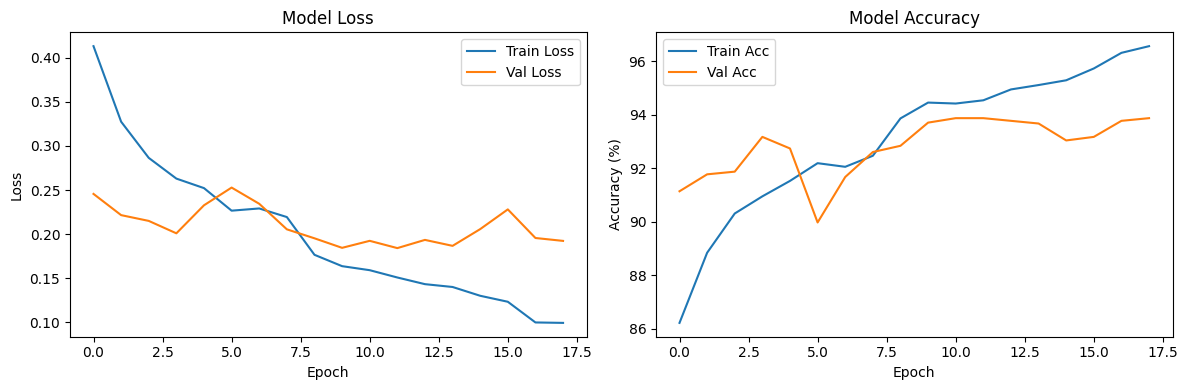


Final Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.94      0.86      0.90       553
    mountain       0.88      0.92      0.90       525
         sea       0.95      0.99      0.97       510
      street       0.94      0.96      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [3]:
# Usage Example
if __name__ == "__main__":
    # Initialize classifier with your dataset structure
    classifier = SceneClassifier(
        data_dir='/kaggle/input/intel-image-classification',  # Your dataset root folder
        num_classes=6,
        img_size=224,
        batch_size=32
    )
    
    # Train the model
    best_accuracy = classifier.train(num_epochs=25, early_stopping_patience=7)